In [7]:
import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold

In [8]:
# Tensorflow2로 MF 구현

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, dot

In [1]:
import pandas as pd
ratings=pd.read_csv('data/ratings.csv')
ratings

,user_id,movie_id,rating
0,195,241,3.0
1,185,301,3.0
2,21,376,1.0
3,243,50,2.0
4,165,345,1.0
...,...,...,...
99995,879,475,3.0
99996,715,203,5.0
99997,275,1089,1.0
99998,12,224,2.0


In [11]:
users=pd.read_csv('data/users.csv')

In [13]:
movies=pd.read_csv('data/movies.csv')

In [2]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user_id   100000 non-null  int64  
 1   movie_id  100000 non-null  int64  
 2   rating    100000 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB


In [3]:
def split_dataframe(df, holdout_fraction=0.1):
  """Splits a DataFrame into training and test sets.
  Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
  Returns:
    train: dataframe for training
    test: dataframe for testing
  """
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

In [4]:
ratings['user_id'] = ratings['user_id'].astype(int)
ratings['movie_id'] = ratings['movie_id'].astype(int)

train_ratings, test_ratings = split_dataframe(ratings)
train_ratings.shape, test_ratings.shape

((90000, 3), (10000, 3))

In [5]:
movielens=pd.read_csv('data/movielens.csv')

In [6]:
movielens

,user_id,movie_id,rating,title,release_date,imdb_url,genre_unknown,Action,Adventure,Animation,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,all_genres,age,sex,occupation
0,195,241,3.0,Kolya (1996),24-Jan-1997,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,0,...,0,0,0,0,0,0,Comedy,49,M,writer
1,195,256,2.0,Men in Black (1997),04-Jul-1997,http://us.imdb.com/M/title-exact?Men+in+Black+...,0,1,1,0,...,0,0,1,0,0,0,Action-Adventure-Comedy-Sci-Fi,49,M,writer
2,195,110,4.0,"Truth About Cats & Dogs, The (1996)",26-Apr-1996,http://us.imdb.com/M/title-exact?Truth%20About...,0,0,0,0,...,0,1,0,0,0,0,Comedy-Romance,49,M,writer
3,195,24,4.0,"Birdcage, The (1996)",08-Mar-1996,"http://us.imdb.com/M/title-exact?Birdcage,%20T...",0,0,0,0,...,0,0,0,0,0,0,Comedy,49,M,writer
4,195,381,4.0,"Adventures of Priscilla, Queen of the Desert, ...",01-Jan-1994,http://us.imdb.com/M/title-exact?Adventures%20...,0,0,0,0,...,0,0,0,0,0,0,Comedy-Drama,49,M,writer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,872,312,5.0,Titanic (1997),01-Jan-1997,http://us.imdb.com/M/title-exact?imdb-title-12...,0,1,0,0,...,0,1,0,0,0,0,Action-Drama-Romance,48,F,administrator
99996,872,325,4.0,G.I. Jane (1997),01-Jan-1997,http://us.imdb.com/M/title-exact?G%2EI%2E+Jane...,0,1,0,0,...,0,0,0,0,1,0,Action-Drama-War,48,F,administrator
99997,872,347,3.0,Desperate Measures (1998),30-Jan-1998,http://us.imdb.com/Title?Desperate+Measures+(1...,0,0,0,0,...,0,0,0,1,0,0,Crime-Drama-Thriller,48,F,administrator
99998,872,357,2.0,Spawn (1997),01-Aug-1997,http://us.imdb.com/M/title-exact?Spawn+(1997/I),0,1,1,0,...,0,0,1,1,0,0,Action-Adventure-Sci-Fi-Thriller,48,F,administrator


In [14]:
n_latent_factors = 30 # user와 movie embedding의 차원수

user_input = Input(shape=[1], name='user')
movie_input = Input(shape=[1], name='movie')

user_embedding = Embedding(input_dim=users.shape[0] # 943
                           , output_dim = n_latent_factors # 30
                           , name='user_embedding'
                           )(user_input)

movie_embedding = Embedding(input_dim=movies.shape[0] # 1682
                           , output_dim = n_latent_factors # 30
                           , name='movie_embedding'
                           )(movie_input)

user_vec = Flatten(name='flatten_users')(user_embedding) # 1차원 배열로 변환
movie_vec = Flatten(name='flatten_movies')(movie_embedding) # 1차원 배열로 변환

product = dot([movie_vec, user_vec], axes=1) # 평점
model = Model(inputs=[user_input, movie_input], outputs=product) # user와 movie가 주어졌을 때, 평점을 예측하는 모델

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 movie (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 user (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 movie_embedding (Embedding)    (None, 1, 30)        50460       ['movie[0][0]']                  
                                                                                                  
 user_embedding (Embedding)     (None, 1, 30)        28290       ['user[0][0]']                   
                                                                                              

In [17]:
model.compile(optimizer='adam', loss='mse')

In [18]:
history = model.fit(x=[train_ratings['user_id'], train_ratings['movie_id']],
                    y=train_ratings['rating'], epochs=500,
                    validation_data=([test_ratings['user_id'], test_ratings['movie_id'] ],
                                     test_ratings['rating']),
                    verbose=1, batch_size=train_ratings.shape[0])

Epoch 1/500
1/1 [==============================] - 3s 3s/step - loss: 13.7115 - val_loss: 13.8682
Epoch 2/500
1/1 [==============================] - 1s 1s/step - loss: 13.7107 - val_loss: 13.8682
Epoch 3/500
1/1 [==============================] - 1s 1s/step - loss: 13.7098 - val_loss: 13.8682
Epoch 4/500
1/1 [==============================] - 1s 1s/step - loss: 13.7089 - val_loss: 13.8681
Epoch 5/500
1/1 [==============================] - 1s 1s/step - loss: 13.7079 - val_loss: 13.8679
Epoch 6/500
1/1 [==============================] - 1s 1s/step - loss: 13.7068 - val_loss: 13.8675
Epoch 7/500
1/1 [==============================] - 2s 2s/step - loss: 13.7057 - val_loss: 13.8670
Epoch 8/500
1/1 [==============================] - 2s 2s/step - loss: 13.7043 - val_loss: 13.8664
Epoch 9/500
1/1 [==============================] - 2s 2s/step - loss: 13.7029 - val_loss: 13.8655
Epoch 10/500
1/1 [==============================] - 2s 2s/step - loss: 13.7012 - val_loss: 13.8644
Epoch 11/500
1/1 [=

In [19]:
model.embeddings = {
    'user_id': model.get_layer('user_embedding').weights[0].numpy(), # U (943, 30)
    'movie_id': model.get_layer('movie_embedding').weights[0].numpy() # V (1682, 30)
}

In [24]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     943 non-null    int64 
 1   age         943 non-null    int64 
 2   sex         943 non-null    object
 3   occupation  943 non-null    object
dtypes: int64(2), object(2)
memory usage: 29.6+ KB


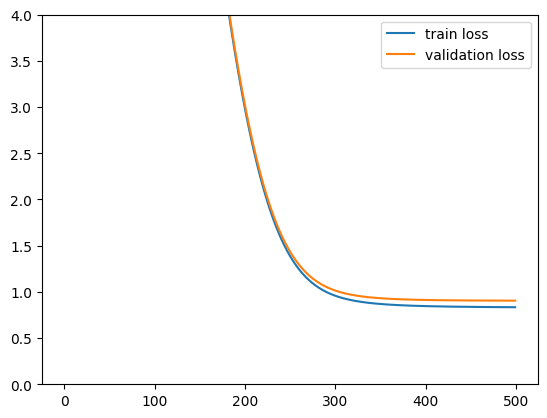

In [25]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train loss', 'validation loss'])
plt.ylim([0,4])
plt.show()

In [26]:
users.tail()

,user_id,age,sex,occupation
938,938,26,F,student
939,939,32,M,administrator
940,940,20,M,student
941,941,48,F,librarian
942,942,22,M,student


In [28]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
  """Computes the scores of the candidates given a query.
  Args:
    query_embedding: a vector of shape [k], representing the query embedding.
    item_embeddings: a matrix of shape [N, k], such that row i is the embedding
      of item i.
    measure: a string specifying the similarity measure to be used. Can be
      either DOT or COSINE.
  Returns:
    scores: a vector of shape [N], such that scores[i] is the score of item i.
  """
  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores
USER_RATINGS = True

In [29]:
def user_recommendations(model, measure=DOT, exclude_rated=False, k=6, user_id=570):
  if USER_RATINGS:
    scores = compute_scores(
        model.embeddings["user_id"][user_id], model.embeddings["movie_id"], measure)
    score_key = measure + ' score'
    df = pd.DataFrame({
        score_key: list(scores),
        'movie_id': movies['movie_id'],
        'titles': movies['title'],
        'genres': movies['all_genres'],
    })
    if exclude_rated:
      # remove movies that are already rated
      rated_movies = ratings[ratings.user_id == str(user_id)]["movie_id"].values
      df = df[df.movie_id.apply(lambda movie_id: movie_id not in rated_movies)]
    return (df.sort_values([score_key], ascending=False).head(k))


In [34]:
def movie_neighbors(model, title_substring, measure=DOT, k=6):
  # Search for movie ids that match the given substring.
  ids =  movies[movies['title'].str.contains(title_substring)].index.values
  titles = movies.iloc[ids]['title'].values
  if len(titles) == 0:
    raise ValueError("Found no movies with title %s" % title_substring)
  print("Nearest neighbors of : %s." % titles[0])
  if len(titles) > 1:
    print("[Found more than one matching movie. Other candidates: {}]".format(
        ", ".join(titles[1:])))
  movie_id = ids[0]
  scores = compute_scores(
      model.embeddings["movie_id"][movie_id], model.embeddings["movie_id"],
      measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'titles': movies['title'],
      'genres': movies['all_genres']
  })
  return (df.sort_values([score_key], ascending=False).head(k))

In [36]:
user_recommendations(model, measure=DOT, k=10, user_id=942, exclude_rated=True)

,dot score,movie_id,titles,genres
1535,4.678007,1535,Aiqing wansui (1994),Drama
813,4.658752,813,"Great Day in Harlem, A (1994)",Documentary
1499,4.640284,1499,Santa with Muscles (1996),Comedy
1466,4.594251,1466,"Saint of Fort Washington, The (1993)",Drama
1598,4.593953,1598,Someone Else's America (1995),Drama
1448,4.559278,1448,Pather Panchali (1955),Drama
1397,4.479471,1397,Anna (1996),Drama
1366,4.476431,1366,Faust (1994),Animation
1641,4.412363,1641,Some Mother's Son (1996),Drama
407,4.408297,407,"Close Shave, A (1995)",Animation-Comedy-Thriller


In [35]:
movie_neighbors(model, "Aladdin", DOT)

Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


,dot score,titles,genres
1535,4.925954,Aiqing wansui (1994),Drama
813,4.909720,"Great Day in Harlem, A (1994)",Documentary
1499,4.859949,Santa with Muscles (1996),Comedy
1466,4.836514,"Saint of Fort Washington, The (1993)",Drama
1598,4.834853,Someone Else's America (1995),Drama
1448,4.804722,Pather Panchali (1955),Drama
